In [2]:
import numpy as np
import rioxarray as rx
import rasterio
from rasterio.mask import mask
from pathlib import Path
import geopandas as gpd
import pprint
import re
import os
import glob
import xarray as xr
import matplotlib.pyplot as plt
import xarray
import pandas as pd
from exactextract import exact_extract
%matplotlib inline

In [88]:
def rename_bands_pp(img):
  







def getName(filename):
  """ takes in filepath and returns the name of the file for a tif 
  """
  name = re.sub(r'^.*/', "", filename)
  name = name.replace(".tif", "")
  name = name.replace("_pp", "")
  return name


def clipRasters(in_path, shpfile, out_path):
 pathlist = Path(in_path).rglob('*.tif')
 for path in pathlist:
  path_in_str = str(path)
  src = rx.open_rasterio(path)
  name = getName(path_in_str)
  print(name)
  src_lonlat = src.rio.reproject("epsg:4326") 
  shp = gpd.read_file(shpfile)
  shp = shp[shp.Fire_ID == name]
  clipped = src_lonlat.rio.clip(shp.geometry.values, shp.crs, drop=True, invert=False)
  out_dir = out_path + name +".tif"
  clipped.rio.to_raster(out_dir, driver="GTiff", compress="LZW")
  
def raster_stats(ras):
  median =  ras.median()
  mean = ras.mean()
  std = ras.std()
  median = median.to_pandas()
  mean = mean.to_pandas()
  std = std.to_pandas()
  cv = std/mean
  return (mean, median, cv)
    
def calc_rbr(ras):
  '''returns a new raster consisting of rbr (2) , and a dataframe consisting of median, mean and cv rbr'''
  pre = ras[0]
  post = ras[1]
  post = post.assign_coords({
    "x": pre.x,
    "y": pre.y,})
  new_raster=(((pre - post)*1000)/ pre + 1.001)
  mean, median, cv = raster_stats(new_raster)
  df = pd.DataFrame({
    "Fire_ID": [name],
    "rbr_median": [median],
    "rbr_mean": [mean],
    "rbr_cv": [cv]
    })
  return (df, new_raster)
    
  
# set scientific notation to non scientific
np.set_printoptions(suppress=True, precision=6)


# Section 1
crop rasters by both defoliated and non-defoliated perimeters and inspect the ouput

In [ ]:
in_path = "/Users/jgoldman/Google Drive/My Drive/chp3-sbw-fire/chapter3_lt_pp/"
shpfl = "/Users/jgoldman/Desktop/OneDrive - University of Toronto/Data/chapter_3/on-qc-defol.shp"
out_path = "/Users/jgoldman/Library/CloudStorage/GoogleDrive-jandrewgoldman@gmail.com/My Drive/chp3-sbw-fire/defol_cropped_pp/"



clipRasters(in_path, shpfl, out_path)


In [91]:
%%capture
in_path = "/Users/jgoldman/Google Drive/My Drive/chp3-sbw-fire/chapter3_lt_pp/"
shpfl = "/Users/jgoldman/Desktop/OneDrive - University of Toronto/Data/chapter_3/on-qc-nondefol.shp"
out_path = "/Users/jgoldman/Library/CloudStorage/GoogleDrive-jandrewgoldman@gmail.com/My Drive/chp3-sbw-fire/non_defol_cropped_pp/"



clipRasters(in_path, shpfl, out_path)

### check outputs 
See if the clip/mask kept only the area within polygon

<xarray.DataArray (band: 2, y: 239, x: 233)>
[111374 values with dtype=float32]
Coordinates:
  * band         (band) int64 1 2
  * x            (x) float64 -80.55 -80.55 -80.55 ... -80.49 -80.49 -80.49
  * y            (y) float64 49.92 49.92 49.92 49.92 ... 49.86 49.86 49.86 49.86
    spatial_ref  int64 0
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0
    long_name:      ('preNBR', 'postNBR')

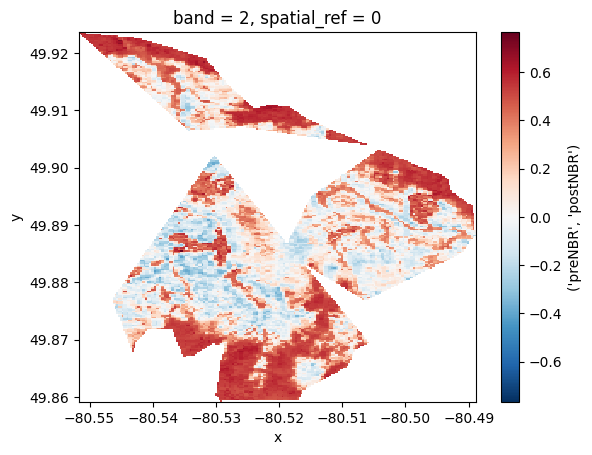

In [31]:
# check raster

fp2= "/Users/jgoldman/Library/CloudStorage/GoogleDrive-jandrewgoldman@gmail.com/My Drive/chp3-sbw-fire/defol_cropped_pp/COC16_1997_1038.tif"
t = rx.open_rasterio(fp2, masked= True,)
t[1].squeeze().plot.imshow()
t

After converting original pp files to netCDF to work better with xarray, lets check to see how it looks



### code to make 3-D array by year

In [256]:
nc2= "/Users/jgoldman/Desktop/chp3/ltr_pre_post/THU37_2007_1662_pp.nc"
t = xr.open_dataset(nc2,decode_coords="all") 
t

preNBR= t.rename_vars(Band1='nbr')['nbr']
postNBR= t.rename_vars(Band2='nbr')['nbr']
preNBR.attrs["long_name"] = "nbr"

preNBR
postNBR = postNBR.assign_coords({
    "lon": preNBR.lon,
    "lat": preNBR.lat,})


postNBR 



ds= xr.concat([preNBR, postNBR], dim=pd.Index([1996, 1998], name ='time'))



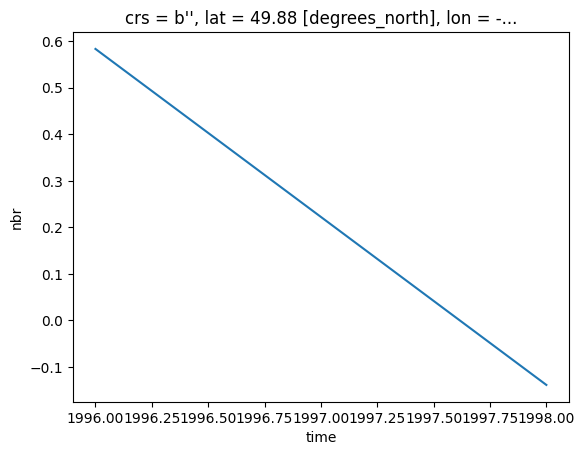

In [122]:
air1d = ds.isel(lat=100, lon=100)

air1d.plot()

# Section 2 - epxlore NBAC

In [252]:
nbac = gpd.read_file('/Users/jgoldman/Library/CloudStorage/GoogleDrive-jandrewgoldman@gmail.com/My Drive/Projects-Data/shield-data/NBAC-shield-1986-2022/nbac-1986-2022-ontario-shield.shp')



In [183]:
nbac2 = nbac

In [177]:
nbac.columns.tolist()
nbac.head()
nbac["COMMENTS"]

0       accuracy:AC Accurate (to 10m),weath_ind:7.0,og...
1       accuracy:AP Approximate (to 500m),weath_ind:8....
2       accuracy:AC Accurate (to 10m),weath_ind:6.0,og...
3       fire_type:IFR,fwi:7,objective:FUL,start_date:2...
4       fire_type:IFR,fwi:24,objective:FUL,start_date:...
                              ...                        
2317                                                 Null
2318                                                 None
2319    fire_type:IFR,fwi:11,objective:MON,start_date:...
2320                                                 Null
2321                                                 None
Name: COMMENTS, Length: 2322, dtype: object

In [184]:
# select comments and filter to coc16
sep = '['


nbac2['COMMENTS'] = nbac2['COMMENTS'].str.replace('(?<=\[).*', "", regex=True)

nbac2.head()

,YEAR,NFIREID,BASRC,FIREMAPS,FIREMAPM,FIRECAUS,BURNCLAS,SDATE,EDATE,AFSDATE,AFEDATE,CAPDATE,POLY_HA,ADJ_HA,ADJ_FLAG,AGENCY,BT_GID,VERSION,COMMENTS,geometry
0,1999.0,694.0,3.0,0.0,3.0,4.0,4.0,None,None,1999-04-23,1999-04-30,None,32.012818,30.372158,2.0,ON,110.0,1999_r9_20210810,SAU4[,"POLYGON ((-83.65634 46.36772, -83.65634 46.367..."
1,1998.0,841.0,3.0,0.0,0.0,4.0,4.0,None,None,1998-04-10,1998-04-11,None,9.442232,9.390455,2.0,ON,508.0,1998_r9_20210810,SAU4[,"POLYGON ((-84.09908 46.41307, -84.09908 46.413..."
2,2000.0,528.0,3.0,0.0,3.0,4.0,4.0,None,None,2000-04-25,2000-05-08,None,28.819582,27.453665,2.0,ON,472.0,2000_r9_20210810,SAU8[,"POLYGON ((-83.99699 46.43096, -83.99699 46.430..."
3,2011.0,722.0,3.0,2.0,3.0,4.0,4.0,2011-10-09,2011-10-09,2011-10-08,2011-10-24,None,709.809516,597.535660,2.0,ON,836.0,2011_r9_20210810,SAU20[,"POLYGON ((-84.30281 46.75777, -84.30758 46.758..."
4,2007.0,388.0,3.0,2.0,3.0,1.0,4.0,2007-05-13,2007-07-30,2007-05-13,2007-06-15,None,1555.108435,1270.104833,2.0,ON,181.0,2007_r9_20210810,SAU13[,"POLYGON ((-83.28152 46.85578, -83.28139 46.855..."


In [191]:
nbac2['COMMENTS'] = nbac2['COMMENTS'].str.replace("[", "")

# change year column to integer
nbac2['YEAR'] = nbac2['YEAR'].astype('int16')

nbac2.head()

#new column which is a concat of comments and year 

nbac2['Fire_ID']=nbac2['COMMENTS'] + "_" + nbac2['YEAR'].astype('str')
nbac2.head()

,YEAR,NFIREID,BASRC,FIREMAPS,FIREMAPM,FIRECAUS,BURNCLAS,SDATE,EDATE,AFSDATE,...,CAPDATE,POLY_HA,ADJ_HA,ADJ_FLAG,AGENCY,BT_GID,VERSION,COMMENTS,geometry,Fire_ID
0,1999,694.0,3.0,0.0,3.0,4.0,4.0,None,None,1999-04-23,...,None,32.012818,30.372158,2.0,ON,110.0,1999_r9_20210810,SAU4,"POLYGON ((-83.65634 46.36772, -83.65634 46.367...",SAU4_1999
1,1998,841.0,3.0,0.0,0.0,4.0,4.0,None,None,1998-04-10,...,None,9.442232,9.390455,2.0,ON,508.0,1998_r9_20210810,SAU4,"POLYGON ((-84.09908 46.41307, -84.09908 46.413...",SAU4_1998
2,2000,528.0,3.0,0.0,3.0,4.0,4.0,None,None,2000-04-25,...,None,28.819582,27.453665,2.0,ON,472.0,2000_r9_20210810,SAU8,"POLYGON ((-83.99699 46.43096, -83.99699 46.430...",SAU8_2000
3,2011,722.0,3.0,2.0,3.0,4.0,4.0,2011-10-09,2011-10-09,2011-10-08,...,None,709.809516,597.535660,2.0,ON,836.0,2011_r9_20210810,SAU20,"POLYGON ((-84.30281 46.75777, -84.30758 46.758...",SAU20_2011
4,2007,388.0,3.0,2.0,3.0,1.0,4.0,2007-05-13,2007-07-30,2007-05-13,...,None,1555.108435,1270.104833,2.0,ON,181.0,2007_r9_20210810,SAU13,"POLYGON ((-83.28152 46.85578, -83.28139 46.855...",SAU13_2007


In [237]:
defol = gpd.read_file("/Users/jgoldman/Desktop/OneDrive - University of Toronto/Data/chapter_3/on-qc-defol.shp")
# change fire id column to match
defol['Fire_ID']= defol['Fire_ID'].str.split('_').str[:2].str.join('_')

defol.head()


,Fire_ID,Fire_Year,defoliated,geometry
0,CHA8_2012,2012,1.0,"POLYGON ((-82.47142 48.33225, -82.46911 48.331..."
1,COC16_1997,1997,1.0,"MULTIPOLYGON (((-80.51622 49.86124, -80.51691 ..."
2,COC23_1995,1995,1.0,"POLYGON ((-81.32426 50.19131, -81.32550 50.191..."
3,COC38_1995,1995,1.0,"MULTIPOLYGON (((-81.51191 50.14156, -81.51111 ..."
4,DRY27_1996,1996,1.0,"MULTIPOLYGON (((-90.36624 50.04934, -90.36621 ..."


In [242]:
#Get list from defol
fireIDs= defol['Fire_ID'].tolist()

#
nbac3 = nbac2.query('Fire_ID.isin(@fireIDs)')

In [269]:
nbac3
thu= nbac3[nbac3.Fire_ID == "THU37_2007"]
thu2 = defol[defol.Fire_ID == "THU37_2007"]

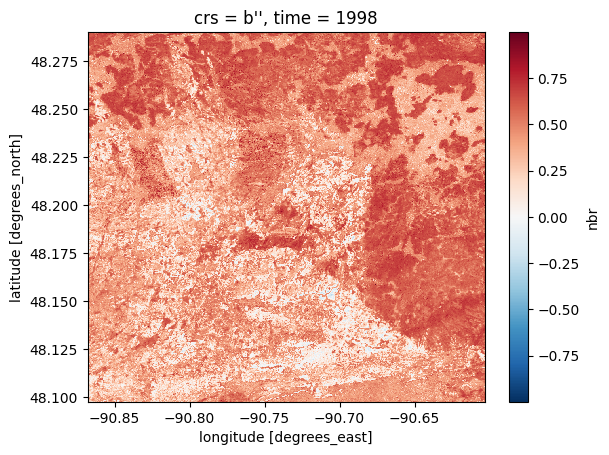

In [259]:
air2d = ds.isel(time=1)

air2d.plot()



<Axes: title={'center': "crs = b'', time = 1998"}, xlabel='longitude [degrees_east]', ylabel='latitude [degrees_north]'>

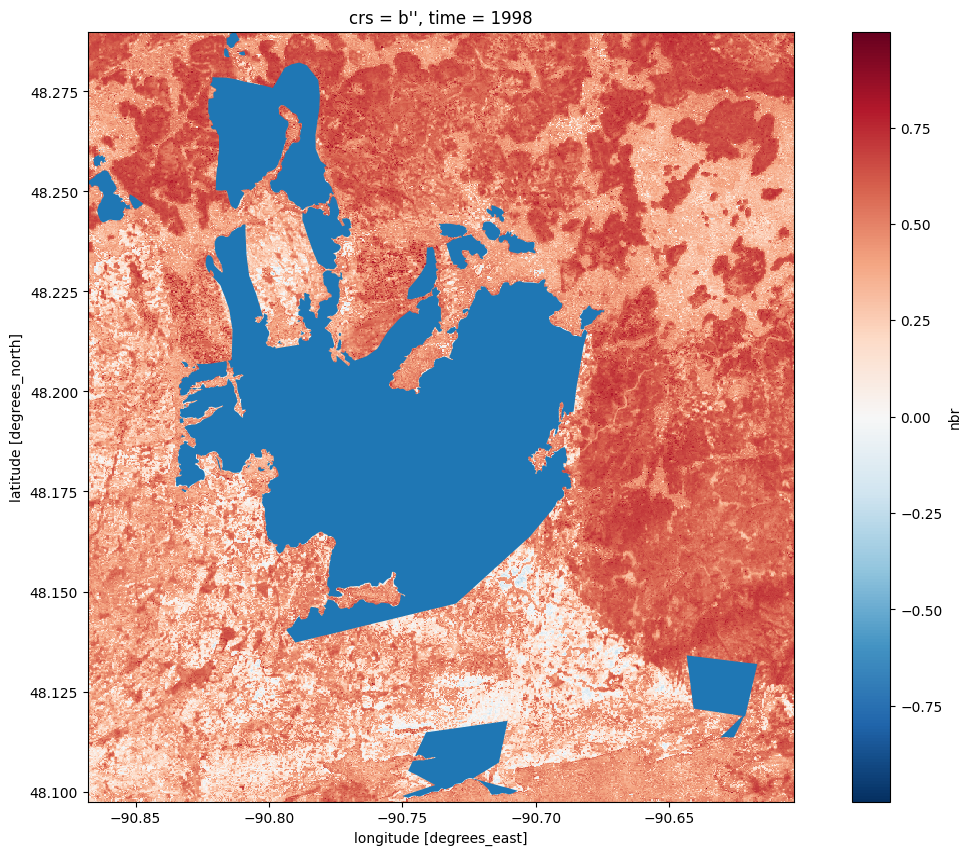

In [270]:
fig, ax = plt.subplots(figsize=(15, 10))
air2d.plot(ax=ax) 
thu2.plot(ax=ax)    # Plot the vector data on the subplot


<Axes: title={'center': "crs = b'', time = 1998"}, xlabel='longitude [degrees_east]', ylabel='latitude [degrees_north]'>

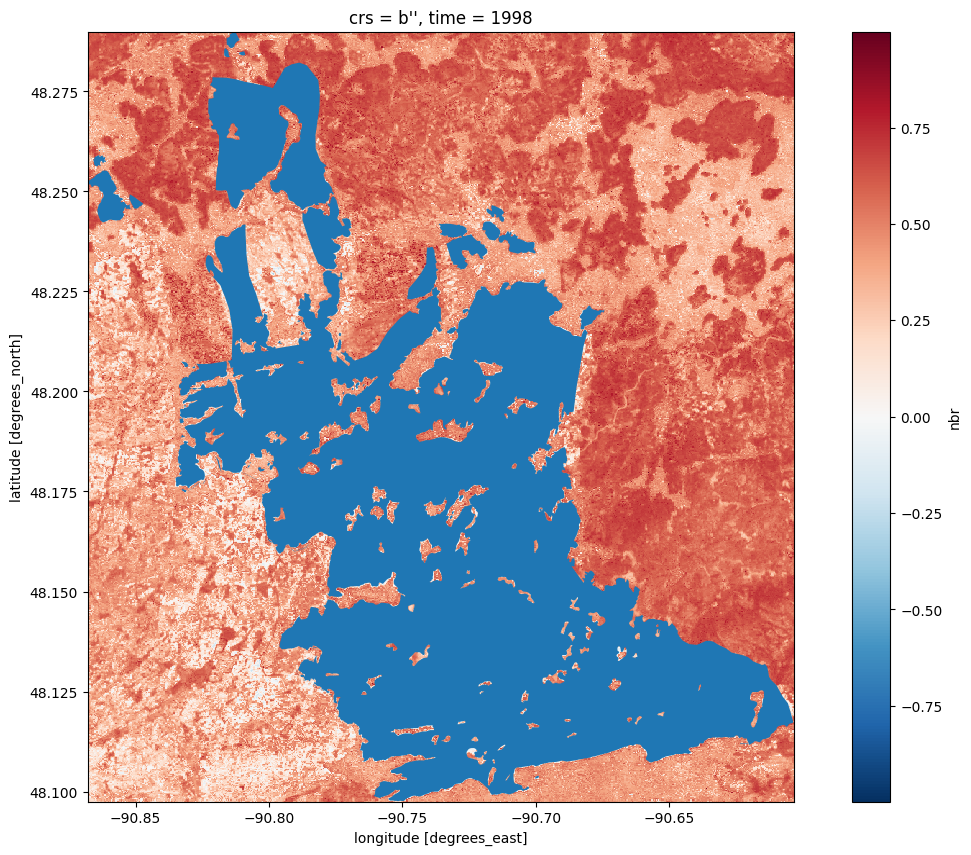

In [271]:
fig, ax = plt.subplots(figsize=(15, 10))
air2d.plot(ax=ax) 
thu.plot(ax=ax)    # Plot the vector data on the subplot


# match each dataframe based on the centroid of each fire perimeter



In [273]:
nbac["centroid"] = nbac["geometry"].centroid

/var/folders/ct/ddw0sd294ls6ktmlw9l8bwgm0000gn/T/ipykernel_27782/1439265844.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  nbac["centroid"] = nbac["geometry"].centroid


In [274]:
defol["centroid"] = defol["geometry"].centroid

/var/folders/ct/ddw0sd294ls6ktmlw9l8bwgm0000gn/T/ipykernel_27782/1813281347.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  defol["centroid"] = defol["geometry"].centroid


In [313]:
defol_w_nbac = defol.sjoin_nearest(nbac, distance_col="centroid", how="left")


/opt/homebrew/lib/python3.11/site-packages/geopandas/array.py:365: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  warnings.warn(


AttributeError: The CRS attribute of a GeoDataFrame without an active geometry column is not defined. Use GeoDataFrame.set_geometry to set the active geometry column.

In [281]:
defol_w_nbac

,Fire_ID,Fire_Year,defoliated,geometry,centroid_x,centroid_y,index_right,YEAR,NFIREID,BASRC,...,AFEDATE,CAPDATE,POLY_HA,ADJ_HA,ADJ_FLAG,AGENCY,BT_GID,VERSION,COMMENTS,centroid
0,CHA8_2012,2012,1.0,"POLYGON ((-82.47142 48.33225, -82.46911 48.331...",POINT (-82.46589 48.33120),0.000000,194,2012.0,1040.0,3.0,...,2012-06-29,None,193.811600,171.535929,2.0,ON,1074.0,2012_r9_20210810,"CHA8[type_c:IFR,weath_ind:23.57,resp_obj_c:FUL...",POINT (-82.46714 48.33321)
1,COC16_1997,1997,1.0,"MULTIPOLYGON (((-80.51622 49.86124, -80.51691 ...",POINT (-80.52080 49.88706),0.000000,305,1997.0,350.0,4.0,...,1997-10-01,None,2700.557627,2700.557627,0.0,ON,1055.0,1997_r9_20210810,None,POINT (-80.54322 49.89333)
2,COC23_1995,1995,1.0,"POLYGON ((-81.32426 50.19131, -81.32550 50.191...",POINT (-81.32506 50.19205),0.005978,785,1995.0,1187.0,4.0,...,1995-08-03,None,7638.842783,7638.842783,0.0,ON,2302.0,1995_r9_20210810,None,POINT (-81.27545 50.25490)
3,COC38_1995,1995,1.0,"MULTIPOLYGON (((-81.51191 50.14156, -81.51111 ...",POINT (-81.57739 50.11347),0.000000,776,1991.0,477.0,4.0,...,None,None,8.016002,8.016002,0.0,ON,1402.0,1991_r9_20210810,None,POINT (-81.63576 50.10785)
3,COC38_1995,1995,1.0,"MULTIPOLYGON (((-81.51191 50.14156, -81.51111 ...",POINT (-81.57739 50.11347),0.000000,777,1995.0,1200.0,4.0,...,1995-10-20,None,1542.331795,1542.331795,0.0,ON,2010.0,1995_r9_20210810,None,POINT (-81.55848 50.12002)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66,QC_783,1996,1.0,"MULTIPOLYGON (((-70.62383 49.28686, -70.62382 ...",POINT (-70.63442 49.28901),7.152357,16,2000.0,527.0,3.0,...,2000-05-11,None,59.724377,55.316311,2.0,ON,286.0,2000_r9_20210810,"KEM2[accuracy:GE General (to 10,000m),weath_in...",POINT (-76.51454 45.19045)
67,QC_788,1996,1.0,"POLYGON ((-70.99031 50.05402, -70.99030 50.053...",POINT (-70.99154 50.05970),7.353654,16,2000.0,527.0,3.0,...,2000-05-11,None,59.724377,55.316311,2.0,ON,286.0,2000_r9_20210810,"KEM2[accuracy:GE General (to 10,000m),weath_in...",POINT (-76.51454 45.19045)
68,QC_792,1996,1.0,"MULTIPOLYGON (((-71.51199 50.35558, -71.51115 ...",POINT (-71.50781 50.35702),7.185422,16,2000.0,527.0,3.0,...,2000-05-11,None,59.724377,55.316311,2.0,ON,286.0,2000_r9_20210810,"KEM2[accuracy:GE General (to 10,000m),weath_in...",POINT (-76.51454 45.19045)
69,QC_81,1991,1.0,"MULTIPOLYGON (((-72.67327 50.06260, -72.67285 ...",POINT (-72.42366 50.14717),6.191332,16,2000.0,527.0,3.0,...,2000-05-11,None,59.724377,55.316311,2.0,ON,286.0,2000_r9_20210810,"KEM2[accuracy:GE General (to 10,000m),weath_in...",POINT (-76.51454 45.19045)


In [314]:
defol_w_nbac_on = defol_w_nbac[defol_w_nbac.AGENCY == "ON"]

In [353]:
substring = "QC"
filter = defol_w_nbac_on['Fire_ID'].str.contains(substring)
filtered_df = defol_w_nbac_on[~filter]

In [354]:
filtered_df['YEAR'] = filtered_df['YEAR'].astype('int16')
filtered_df = filtered_df.rename(columns={'YEAR': 'year'})
filtered_df['Fire_Year'] = filtered_df['Fire_Year'].astype('int16')
f = filtered_df.query("Fire_Year == year")



f.to_file("/Users/jgoldman/Desktop/chp3/fire_perimeters/nbac/on-matched-pairs-nbac-full-perimeter.shp", driver='ESRI Shapefile')


/opt/homebrew/lib/python3.11/site-packages/geopandas/geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/var/folders/ct/ddw0sd294ls6ktmlw9l8bwgm0000gn/T/ipykernel_27782/2088089401.py:6: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  f.to_file("/Users/jgoldman/Desktop/chp3/fire_perimeters/nbac/on-matched-pairs-nbac-full-perimeter.shp", driver='ESRI Shapefile')


ValueError: GeoDataFrame contains multiple geometry columns but GeoDataFrame.to_file supports only a single geometry column. Use a GeoDataFrame.to_parquet or GeoDataFrame.to_feather, drop additional geometry columns or convert them to a supported format like a well-known text (WKT) using `GeoSeries.to_wkt()`.

### get NFIREIDs from f file, remove all current geometries in f, and filter nbac for nfireids, and then left join